In [16]:
import numpy as np
from scipy import signal
import scipy.spatial.distance as distfuncs
import scipy.special as special
import scipy.signal as signal
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
from tqdm import tqdm

# test
import sys
sys.path.append('../')
import irutilities as irutil
import sf_func as sf

In [17]:
# Load ir data
sessionName = "S1-M3969_npy"
sessionPath = Path('..').joinpath(sessionName)
posAll, posSrc, irAll = irutil.loadIR(sessionPath)

# Sampling rate (original)
samplerate_raw = 48000

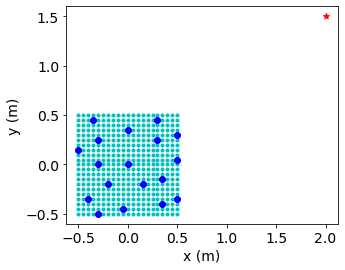

In [18]:
# Microphone selection by the method proposed in
# Nishida, Ueno, Koyama, and Saruwatari, Proc. EUSIPCO, DOI: 10.23919/Eusipco47968.2020.9287222, 2020.
numMic = 18  # Number of mics
idxMic_all = np.load('mic_idx.npy')
idxMic_sel = idxMic_all[0:numMic]

# Evaluation points
idxEval = np.where(np.isclose(posAll[:,2], 0.0))[0]  # xy-plane at z=0
numEval = idxEval.shape[0]
posEval = posAll[idxEval,:]

posEvalX = np.unique(posEval[:,0].round(4))
posEvalY = np.unique(posEval[:,1].round(4))
posEvalZ = np.unique(posEval[:,2].round(4))
numEvalXYZ = (posEvalX.shape[0], posEvalY.shape[0], posEvalZ.shape[0])

# Microphone positions
idxMic = []
for i in range(numMic):
    idx = np.where(np.isclose(idxEval, idxMic_sel[i]))[0]
    idxMic.append(idx[0])

posMic = posEval[idxMic,:]

idxMicXY = []
for i in range(numMic):
    idxX = np.where(np.isclose(posEvalX, posMic[i,0]))[0]
    idxY = np.where(np.isclose(posEvalY, posMic[i,1]))[0]
    idxMicXY.append([idxX[0], idxY[0]])
idxMicXY = np.array(idxMicXY)

# Plot geometry
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='c')
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='b')
ax.scatter(posSrc[:,0], posSrc[:,1], marker='*', color='r')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [19]:
# Load wav file whose channels is supposed to be 1
data_rate, data = wf.read('../jsut_ver1.1/travel1000/wav/TRAVEL1000_0001.wav')
assert(data_rate == samplerate_raw)
print(data.shape)
print(irAll.shape)

data = data / 32767.0
irAll = signal.fftconvolve(irAll, data[None, None, :], axes=2)
_max_val = max(np.absolute(irAll[0, 0, :]))
_saved = (irAll[0, 0, :] * 32767 / _max_val).astype(np.int16)
wf.write('./output/music1.wav', data_rate, _saved)

(170400,)
(1, 3969, 32768)


In [20]:
# IRs for evaluation
irEval = irAll[0,idxEval,:]

# Downdsampling
downSampling = 6
irEval = signal.resample_poly(irEval, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

# IR length
irLen = irEval.shape[1]
print('ir length:', irLen)

# Evaluation signal
maxFreq = 1500
h = signal.firwin(numtaps=64, cutoff=maxFreq, fs=samplerate) # 長さ64のローパスフィルタ
sigEval = signal.filtfilt(h, 1, irEval, axis=-1) # hをかける
# sigEval = irEval

# Observed signal at microphones
# sigMic = sigEval[idxMic,:]

# # Time 
# sigLen = sigEval.shape[1]
# t = np.arange(sigLen)/samplerate

# # Draw pressure distribution
xx, yy = np.meshgrid(posEvalX, posEvalY)

# posEvalXY, sigEvalXY, _ = irutil.sortIR3(posEval, sigEval[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
# sigEvalXY = np.squeeze(sigEvalXY)

# tIdx = 1422

# fig, ax = plt.subplots()
# ax = plt.axes()
# color = plt.pcolor(xx, yy, sigEvalXY[:,:,tIdx], cmap='RdBu', shading='auto', vmin=-0.025, vmax=0.025)
# ax.scatter(posMic[:,0], posMic[:,1], s=30, marker='o', color='w')
# ax.scatter(posMic[:,0], posMic[:,1], s=20, marker='o', color='k')
# ax.set_aspect('equal')
# cbar=plt.colorbar(color)
# cbar.set_label('Amplitude')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.show()


samplerate (Hz):  8000
ir length: 33862


(441, 33862)
(441, 8000)
(441, 8192)


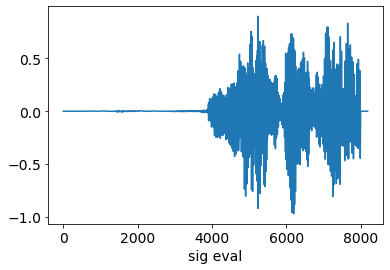

# of frames:  32
constraint:  l2


 50%|█████     | 16/32 [00:03<00:03,  5.22it/s]

(257, 441)
(257, 18, 1)
(257, 441, 18)


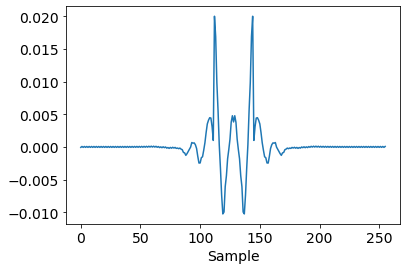

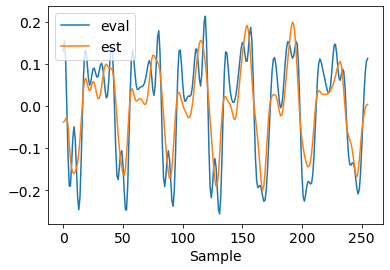

100%|██████████| 32/32 [00:06<00:00,  4.98it/s]

(441, 8192)


In [21]:
# Sound speed (m/s)
c = 347.3

# Regularization parameter
kerReg = 1e-1

# FFT parameters
# fftlen = 16384
# fftlen = pow(2, int(np.ceil(np.lib.scimath.log2(irEval.shape[1]))))
# print(fftlen)
fftlen = 256

# Filter parameters
smplShift = 128
filterLen = 256
# freq = np.arange(1,fftlen/2+1)/fftlen*samplerate

# for debug
print(sigEval.shape)
# sigEval = sigEval[:, :8000]

num_frames = (sigEval.shape[1]+filterLen-1)//filterLen
print(sigEval.shape)
sigEval = np.pad(sigEval, ((0, 0), (0, num_frames * filterLen - sigEval.shape[1])), 'constant')
posEvalXY, sigEvalXY, _ = irutil.sortIR3(posEval, sigEval[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
sigEvalXY = np.squeeze(sigEvalXY)
print(sigEval.shape)

sigMic = sigEval[idxMic,:]
fig, ax = plt.subplots()
ax.plot(sigEval[0,:])
plt.xlabel('sig eval')
plt.show()

num_mic_est = sigEval.shape[0]

# Kernel interpolation filter
# k = 2 * np.pi * freq / c
# kiFilter = sf.kiFilterGen(k, posMic, posEval, filterLen, smplShift)

# specMic = np.fft.fft(sigMic, n=fftlen, axis=1)
# fig, ax = plt.subplots()
# tmp = np.sort(np.sum(np.abs(specMic[:, k.shape[0]:]), axis=0))
# ax.plot(tmp)
# plt.show()


# kiFilter = sf.kiFilterGenWithOpt(k, posMic, posEval, specMic, 'l2', filterLen, smplShift)

# _fs, _ts, stftSpecMic = signal.stft(sigMic, fs=samplerate, window='hamming', nperseg=256, noverlap=0)
# print(_fs)
# print(_ts)
# print(stftSpecMic.shape)

half_width = (filterLen + filterLen - 2) // 2

sigEst = np.zeros((num_mic_est, sigEval.shape[1] + 2 * (filterLen - 1) + filterLen)) # TODO
print("# of frames: ", num_frames)
constraint = 'l1'
print("constraint: ", constraint)
for idx in tqdm(np.arange(num_frames)):
	# win = np.hamming(filterLen)
	specMic = np.fft.rfft(sigMic[:, filterLen*idx:filterLen*(idx+1)], axis=1)
	_fs = np.fft.rfftfreq(filterLen, d=1./samplerate)
	k = 2 * np.pi * _fs / c
	# kiFilter = sf.kiFilterGenWithOpt(k, posMic, posEval, specMic, constraint, filterLen, smplShift)
	kiFilter = sf.kiFilterGen(k, posMic, posEval, filterLen, smplShift)

	# specMic = F x M
	# specKiFilter = F x M x Mest
	specMic = np.fft.rfft(sigMic[:, filterLen*idx:filterLen*(idx+1)].T, n=2*filterLen, axis=0)[:,:,None]
	specKiFilter = np.fft.rfft(kiFilter, n=2*filterLen, axis=0)

	tmpSpecEst = np.squeeze(specKiFilter @ specMic)
	assert(tmpSpecEst.shape[0] == specKiFilter.shape[0])
	assert(tmpSpecEst.shape[1] == specKiFilter.shape[1])
	temp_sig_est = np.fft.irfft(tmpSpecEst, axis=0)#[smplShift:2*filterLen-1+smplShift, :]

	# sigEst[:, filterLen * (idx + 1) - half_width:filterLen * (idx + 1) + half_width + 1] = temp_sig_est.T
	sigEst[:, filterLen * (idx + 1) - half_width:filterLen * (idx + 1) + half_width + 1] += temp_sig_est[:-1, :].T

	if idx == num_frames//2:
		print(tmpSpecEst.shape)
		print(specMic.shape)
		print(specKiFilter.shape)
		fig, ax = plt.subplots()
		ax.plot(kiFilter[:,0,0])
		plt.xlabel('Sample')
		plt.show()
		fig, ax = plt.subplots()
		ax.plot(sigEval[0,filterLen*idx:filterLen*(idx+1)], label='eval')
		ax.plot(np.fft.irfft(tmpSpecEst, axis=0)[smplShift:smplShift+filterLen, 0].T, label='est')
		plt.xlabel('Sample')
		plt.legend()
		plt.show()
	

# sigEst = sigEst[:, filterLen-1: -(filterLen-1)]
sigEst = sigEst[:, smplShift:smplShift+sigEval.shape[1]]
print(sigEst.shape)



In [22]:
_max_val = max(np.absolute(sigEst[0, :]))
_saved = (sigEst[0, :] * 32767 / _max_val).astype(np.int16)
wf.write('./output/est_music1.wav', samplerate, _saved)

In [23]:
# Convolution inerpolation filter
# specMic = np.fft.fft(sigMic.T, n=fftlen, axis=0)[:,:,None]
# specKiFilter = np.fft.fft(kiFilter, n=fftlen, axis=0)

# specEst = np.squeeze(specKiFilter @ specMic)
# print(specEst.shape)
# sigEst = np.fft.ifft(specEst, n=fftlen, axis=0).real.T
# sigEst = sigEst[:,smplShift:sigLen+smplShift]

# Mean square error of estimation
mse = 10*np.log10(np.sum(np.abs(sigEst - sigEval)**2) / np.sum(np.abs(sigEval)**2))
print('MSE: ', mse)

posEstXY, sigEstXY, _ = irutil.sortIR3(posEval, sigEst[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
sigEstXY = np.squeeze(sigEstXY)

# Error distribution
distErr = 10*np.log10(np.sum(np.abs(sigEstXY - sigEvalXY) ** 2, axis=-1) / np.sum(np.abs(sigEvalXY) ** 2, axis=-1))


MSE:  -5.868866179399172


In [24]:
# Draw pressure distribution

# tIdx = 1422

# plt.rcParams["font.size"] = 14

# fig, ax = plt.subplots()
# ax = plt.axes()
# color = plt.pcolor(xx, yy, sigEvalXY[:,:,tIdx], cmap='RdBu', shading='auto', vmin=-0.025, vmax=0.025)
# ax.scatter(posMic[:,0], posMic[:,1], s=30, marker='o', color='w')
# ax.scatter(posMic[:,0], posMic[:,1], s=20, marker='o', color='k')
# ax.set_aspect('equal')
# cbar=plt.colorbar(color)
# cbar.set_label('Amplitude')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.savefig("reconst_true.pdf")

# fig, ax = plt.subplots()
# ax = plt.axes()
# color = plt.pcolor(xx, yy, sigEstXY[:,:,tIdx], cmap='RdBu', shading='auto', vmin=-0.025, vmax=0.025)
# ax.scatter(posMic[:,0], posMic[:,1], s=30, marker='o', color='w')
# ax.scatter(posMic[:,0], posMic[:,1], s=20, marker='o', color='k')
# ax.set_aspect('equal')
# cbar=plt.colorbar(color)
# cbar.set_label('Amplitude')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# fig.savefig("reconst_est.pdf")

# # Draw error distribution

# fig, ax = plt.subplots()
# ax = plt.axes()
# color = plt.pcolor(xx, yy, distErr, cmap='magma', shading='auto', vmin=-20.0, vmax=0.0)
# ax.scatter(posMic[:,0], posMic[:,1], s=30, marker='o', color='w')
# ax.scatter(posMic[:,0], posMic[:,1], s=20, marker='o', color='k')
# ax.set_aspect('equal')
# cbar=plt.colorbar(color)
# cbar.set_label('Error (dB)')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# fig.savefig("reconst_error.pdf")

# plt.show()